In [156]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/Dominik/R-workspace/cecelia/inst')

# MacOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

MATLAB engine not found, bypassing MATLAB module...
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [208]:
base_dir = '/Volumes/USER_data/Dominik/CECELIA_BACKUP/uh0h3c/ANALYSIS/'
zero_dir = os.path.join(base_dir, '0/4i3bxX/')
#im_path = os.path.join(zero_dir, 'ccidImage.ome.zarr')
#im_path = os.path.join(zero_dir, 'ccidCorrected.zarr')
im_path = os.path.join(zero_dir, 'ccidSlidingWindow.zarr')
version_num = 1
task_dir = os.path.join(base_dir, str(version_num), '4i3bxX')

In [189]:
from py.napari_utils import NapariUtils

napari_utils = NapariUtils()
napari_utils.open_viewer()
napari_utils.task_dir = task_dir

napari.manifest -> 'skan' could not be imported: Could not find file 'napari.yaml' in module 'skan'


In [190]:
channel_names = [
    # 'EB', 'T-A', 'T-B', 'AF', 'gen'
    'One'
]

In [191]:
napari_utils.open_image(
    im_path,
    use_channel_axis = True, as_dask = True,
    downsample_z = False, squeeze = False
)

<zarr.hierarchy.Group '/' read-only>
[1, 2, 4, 461, 578]
[578, 461, 4, 2, 1]
['X', 'Y', 'Z', 'C', 'T']
[1, 2, 4, 461, 578]


In [192]:
napari_utils.dim_utils.dim_idx('T')

0

In [ ]:
napari_utils.show_labels_all(
    show_labels = True,
    show_points = False,
    show_tracks = False,
    show_branching = True,
    binarise_labels = True,
    branching_property = 'type',
    value_names = ['SHG', 'SHG.branch']
)

In [3]:
import py.zarr_utils as zarr_utils

In [ ]:
napari_utils.im_data[0].shape

In [ ]:
im = np.average(zarr_utils.fortify(napari_utils.im_data[0][:,3,:,:,:]), axis = 0)
im.shape

In [ ]:
#im = np.average(zarr_utils.fortify(napari_utils.im_data[0][:,5,:,:,:]), axis = 0)[3,:,:]

In [166]:
import py.ILEE_CSK as ILEE_CSK
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

from IPython.utils import io

In [250]:
import py.zarr_utils as zarr_utils

im_path = '/Volumes/USER_data/Dominik/Experiments/KL-Cornea/Mengliang/Tests/MW_P011_inf_exp1.tif'
#im_path = '/Volumes/USER_data/Dominik/Experiments/KL-Cornea/Mengliang/Tests/MW_P011_whorl_exp2.tif'
im_dat, _ = zarr_utils.open_image_as_zarr(im_path)
im_dat = im_dat[0]
im = np.average(im_dat, axis=0)

In [251]:
# https://github.com/phylars/ILEE_CSK/wiki/Tutorial
k1 = 2.5
k2 = 300

img = np.copy(im)
img[img < np.percentile(im, 90)] = 0
img = img-img.min()
img = img.astype('float')

im_diff = ILEE_CSK.ILEE_2d(
    img, k2 = k2, k1 = k1, pL_type = 'pL_8', gauss_dif = True)

starting pre-processing the sample...
Start generating local threshold using ILEE...
Current image shape is (461, 578)
saved image shape is (594, 751)
generating first laplacian matrix or regenerating laplacian matrix due to change of image size.
current image shape and type for laplacian matrix: (461, 578) pL_8
start solving
ILEG linear solver parameters generated; solving time: 2.2483057975769043
Current sample does not need to regenerate laplacian matrix
start solving
ILEG linear solver parameters generated; solving time: 6.877889156341553
starting post-processing the sample...


In [252]:
from skimage.morphology import skeletonize
import skan

img_binary = im_diff>0
img_sk = skeletonize(img_binary).astype('bool')
radius=40
box_size=radius/2
weighting_method='by_length'
return_box_data=False

sk_data = skan.Skeleton(img_sk)
adj = sk_data.nbgraph
point_list = sk_data.coordinates
shape_tuple = img_sk.shape

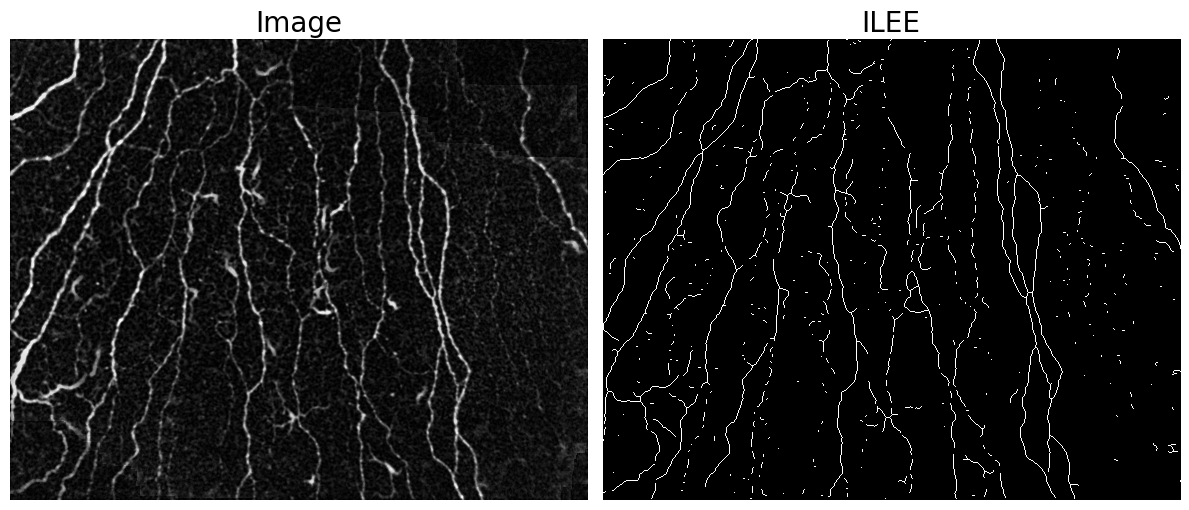

In [253]:
# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Image', fontsize=20)

ax[1].imshow(img_sk, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('ILEE', fontsize=20)

fig.tight_layout()
plt.show()

In [256]:
# get anisotropy
eigval, eigvec, box_total_length, coor_list = ILEE_CSK.anisotropy_2d_internal(
    shape=shape_tuple, adj=adj, point_list=point_list, radius=radius, box_size=box_size)

In [270]:
import math
aniso_radius = 40

ilee_summary, ilee_anisotropy = ILEE_CSK.analyze_actin_2d_standard(
    im, im_diff,
    pixel_size = napari_utils.dim_utils.im_physical_size('x'),
    aniso_radius = aniso_radius,
    aniso_box_size = math.floor(aniso_radius/2),
    return_box_data = True
)

ext_props_tables = list()
ext_props_tables.append(ilee_summary)

start analyzing actin binary image...
Note: output length unit: pixel unit (PU)


In [278]:
import pandas as pd

a = ilee_summary.astype(np.float32)

In [280]:
a.dtypes

occupancy                         float32
linear_density (PU/PU^2)          float32
skewness                          float32
cv                                float32
Diameter_tdt (PU)                 float32
Diameter_sdt (PU)                 float32
sev_act (/PU of filament)         float32
branching_act(/PU of filament)    float32
anisotropy                        float32
dtype: object

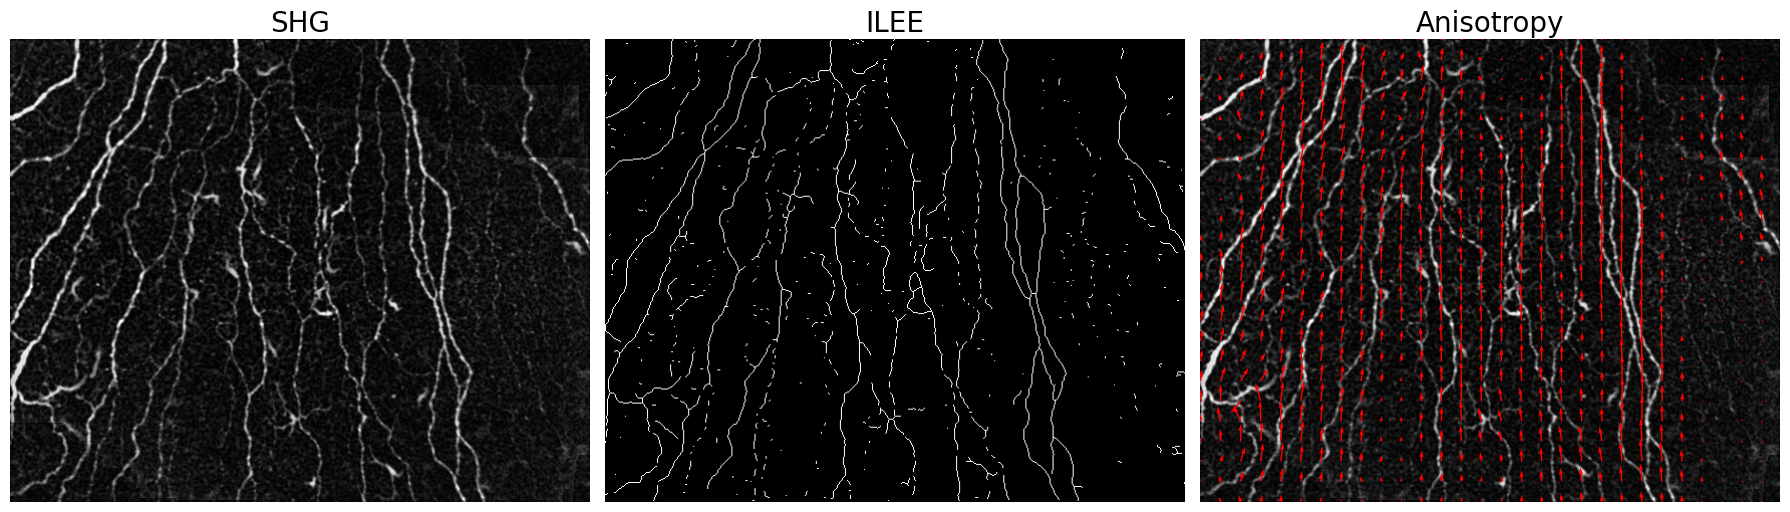

In [255]:
import numpy as np 
import matplotlib.pyplot as plt 

# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('SHG', fontsize=20)

ax[1].imshow(img_sk, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('ILEE', fontsize=20)

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].quiver(
    coor_list[:,:,1].flatten(),
    coor_list[:,:,0].flatten(),
    eigval[:,:,1].flatten() * eigvec[:,:,0,1].flatten(),
    eigval[:,:,0].flatten() * eigvec[:,:,0,0].flatten(),
    color = 'red'
) 
ax[2].set_aspect('equal', 'box')
ax[2].axis('off')
ax[2].set_title('Anisotropy', fontsize=20)

fig.tight_layout()
plt.show()

In [229]:
# can you now detect motion of cells in that image?
import cv2

In [238]:
# get delta for timeframes
t_delta = cv2.absdiff(im_dat[1,:,:], im_dat[2,:,:])

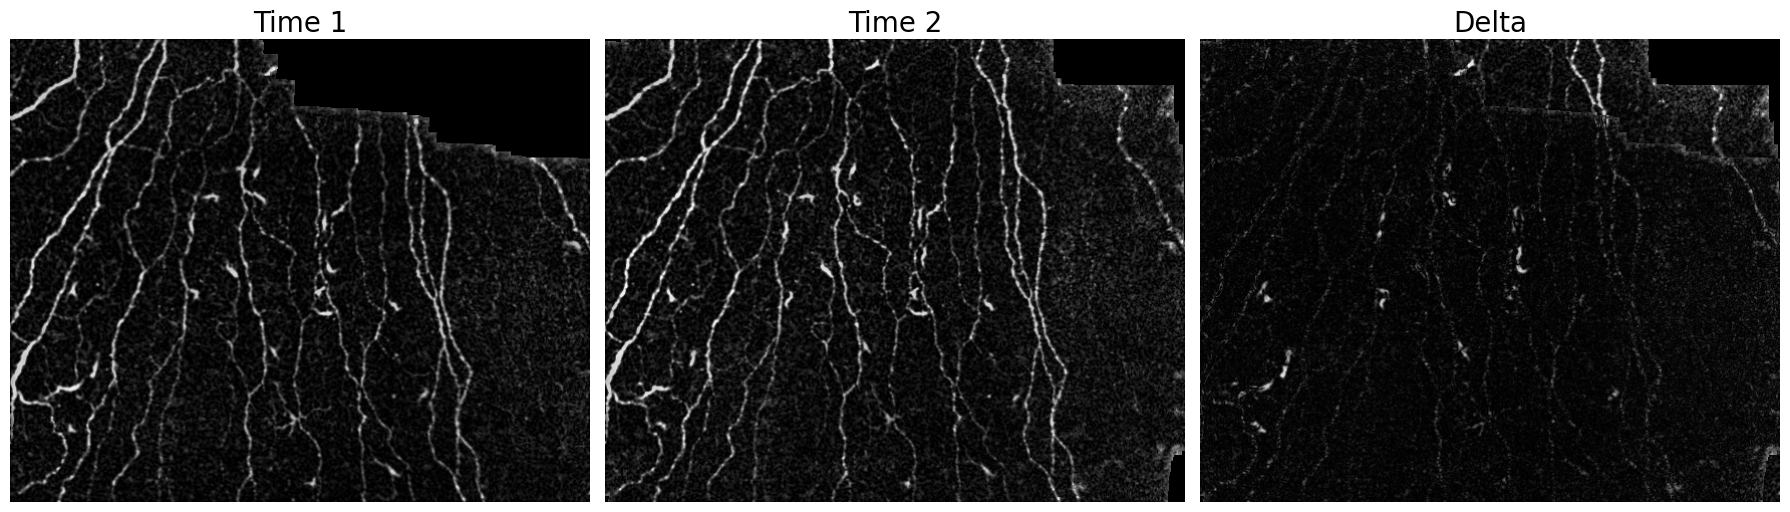

In [239]:
# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(im_dat[1,:,:], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Time 1', fontsize=20)

ax[1].imshow(im_dat[2,:,:], cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Time 2', fontsize=20)

ax[2].imshow(t_delta, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Delta', fontsize=20)

fig.tight_layout()
plt.show()

In [ ]:
for i in range(napari_utils.dim_utils.dim_val('z')):
    im_slices = list(im_slices)
    im_slices[z_idx] = slice(i, i+1, 1)
    im_slices = tuple(im_slices)
    
    print(f'>> Process Z: {i}')
    
    # https://stackoverflow.com/a/52559560
    with io.capture_output() as captured:
        diff_im[im_slices] = ILEE_CSK.ILEE_2d(
            np.squeeze(img[im_slices]), k2 = k2, k1 = k1, pL_type = 'pL_8', gauss_dif = True)

# binarise
bin_im = diff_im > 0

In [ ]:
diff_im.dtype

In [ ]:
# get quantification
sk_df = ILEE_CSK.analyze_actin_3d_standard(
    img, diff_im,
    napari_utils.dim_utils.im_physical_size('x'),
    napari_utils.dim_utils.im_physical_size('z'),
    # TODO this takes a long time - not sure this is necessary for our case?
    # oversampling_for_bundle = True,
    oversampling_for_bundle = False,
    pixel_size = napari_utils.dim_utils.im_physical_size('x')
)

In [ ]:
labels.ndim

In [ ]:
from scipy import ndimage as ndi

contours = np.copy(labels)
eroded_labels = np.copy(labels)
thickness = 1
background_label = 0

# go through all z-axis
for i in range(labels.shape[0]):
    cur_labels = labels[i,:,:]
    
    # adapted from from napari
    # https://github.com/napari/napari/blob/996f502a7f94f68275625dd8b9e94978167f63f9/napari/layers/labels/_labels_utils.py#L208
    struct_elem = ndi.generate_binary_structure(cur_labels.ndim, 1)
    thick_struct_elem = ndi.iterate_structure(struct_elem, thickness).astype(bool)

    dilated_labels = ndi.grey_dilation(cur_labels, footprint=struct_elem)
    eroded_labels[i,:,:] = ndi.grey_erosion(cur_labels, footprint=thick_struct_elem)
    not_boundaries = dilated_labels == eroded_labels[i,:,:]

    contours[i,:,:][not_boundaries] = background_label
    eroded_labels[i,:,:] = eroded_labels[i,:,:] - contours[i,:,:]

In [ ]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt

# perform skeletonization
skeleton = skeletonize(contours)

# now convert to skan
import skan

sk_skeleton = skan.Skeleton(skeleton)
paths_table = skan.summarize(sk_skeleton)

In [ ]:
from skimage.util import invert

bin_labels = np.copy(eroded_labels)
bin_labels[bin_labels > 0] = 2
bin_labels[bin_labels == 0] = 1
bin_labels[bin_labels == 2] = 0

from skimage.morphology import (erosion, dilation, opening, closing,
                                white_tophat)

morph_labels = white_tophat(bin_labels, ndi.generate_binary_structure(bin_labels.ndim, 1))

# perform skeletonization
skeleton = skeletonize(morph_labels)

# display results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

z_val = 8
ax[0].imshow(bin_labels[z_val,:,:], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Bin', fontsize=20)

ax[1].imshow(morph_labels[z_val,:,:], cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Contours', fontsize=20)

ax[2].imshow(np.max(skeleton, axis=0), cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Skeleton', fontsize=20)

fig.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage.color import label2rgb
from skimage.filters import sobel
from skimage.morphology import dilation, disk
from skimage.measure import label
from skimage.segmentation import expand_labels, watershed

coins = data.coins()

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

# expanded = expand_labels(seg1, distance=10)
expanded = dilation(seg1, disk(20))

# Show the segmentations.
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(9, 5),
    sharex=True,
    sharey=True,
)

axes[0].imshow(coins, cmap="Greys_r")
axes[0].set_title("Original")

color1 = label2rgb(seg1, image=coins, bg_label=0)
axes[1].imshow(color1)
axes[1].set_title("Sobel+Watershed")

color2 = label2rgb(expanded, image=coins, bg_label=0)
axes[2].imshow(color2)
axes[2].set_title("Expanded labels")

for a in axes:
    a.axis("off")
fig.tight_layout()
plt.show()


In [ ]:
all([True, False])

In [ ]:
import py.slice_utils as slice_utils

In [ ]:
zarr_shape = list(napari_utils.im_data[0].shape)
zarr_shape.pop(napari_utils.dim_utils.dim_idx('C'))

In [ ]:
a = [[.1],[2],[34]]

In [ ]:
a[1].insert(0, 1)

In [ ]:
a

In [ ]:
slice_utils.create_slices(
  zarr_shape, napari_utils.dim_utils, 1000, -1,
  block_size_z = -1, overlap_z = -1)

In [ ]:
napari_utils.show_labels_all(
    show_labels = True,
    show_points = False,
    show_tracks = False,
    show_branching = True,
    branching_property = 'weight',
    value_names = ['SHG.branch']
)

In [ ]:
napari_utils.show_labels_all(
    show_labels = False,
    show_points = False,
    show_tracks = True,
    value_names = ['P14-CTDR']
)

In [ ]:
# get timescale
napari_utils.time_interval = 0.5

In [ ]:
napari_utils.viewer.text_overlay.position = napa

In [ ]:
def update_slider(event):
    # https://forum.image.sc/t/napari-how-add-a-text-label-time-always-in-the-same-spot-in-viewer/52932/5
    time = napari_utils.viewer.dims.current_step[0]
    napari_utils.viewer.text_overlay.text = str(datetime.timedelta(seconds = time * napari_utils.time_interval * 60))

import datetime

napari_utils.viewer.text_overlay.position
napari_utils.viewer.text_overlay.visible = True
napari_utils.viewer.text_overlay.font_size = 12
napari_utils.viewer.text_overlay.color = 'white'
napari_utils.viewer.dims.events.current_step.connect(update_slider)

In [ ]:
napari_utils.im_scale

In [ ]:
napari_utils.show_labels_all(
    show_labels = True,
    show_points = False,
    show_tracks = False,
    value_names = ['manual'],
    as_np_array = True
)

In [ ]:
# show populations
napari_utils.show_pop_mapping('live')

In [ ]:
# save image as tiff
import py.tiff_utils as tiff_utils

tiff_utils.save_as_tiff(
    '/Volumes/USER_data/Dominik/Experiments/TEAGEN_SKIN/DATA/PuJo5p.tif',
    napari_utils.im_data[0], napari_utils.dim_utils, imagej = True)

In [ ]:
print('here')

In [ ]:
napari_utils.im_scale

In [ ]:
from napari_animation import AnimationWidget
animation_widget = AnimationWidget(napari_utils.viewer)
napari_utils.viewer.window.add_dock_widget(animation_widget, area='right')

In [ ]:
pop_type = 'live'
pop_map = napari_utils.pop_utils.pop_map(napari_utils.task_dir, pop_type)
pop_data = napari_utils.pop_utils.pop_data(napari_utils.task_dir, pop_type)

In [ ]:
pop_info = pop_map['5iaWSo']

In [ ]:
pop_info